In [6]:
import os
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import datetime
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [7]:
modelname = 'MNASNet 1.3'
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size for MNASNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the paths for the datasets
base_folder = "../datasets/Vision_data"
train_folder = os.path.join(base_folder, "train")
test_folder = os.path.join(base_folder, "test")
validation_folder = os.path.join(base_folder, "validation")

# Create datasets
train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=transform)
validation_dataset = ImageFolder(root=validation_folder, transform=transform)

batchsize = 128
numworkers = 4
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train_one_epoch(model, data_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []

    # Update the tqdm description to show current epoch
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

In [9]:
def evaluate(model, data_loader, criterion, device, epoch, num_epochs, phase='Validation'):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []

    # Update the tqdm description to show current epoch and phase (Validation or Testing)
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} - {phase}"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
            
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
            
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

In [10]:
output_folder = "../output/"

# Load and modify the pretrained MnasNet V1.3 model
model = models.mnasnet1_3(weights=models.MNASNet1_3_Weights.IMAGENET1K_V1)
num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler - define your warmup_cosine_annealing scheduler here

num_epochs = 20
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1**(epoch // 30))

writer = SummaryWriter('../runs/MnasNet_1_3_experiment')

# Initialize DataFrame to store metrics
columns = [
    'Epoch', 'Training Loss', 'Validation Loss', 'Test Loss',
    'Training Accuracy', 'Validation Accuracy', 'Test Accuracy',
    'Training Precision', 'Training Recall', 'Training F1-Score',
    'Validation Precision', 'Validation Recall', 'Validation F1-Score',
    'Test Precision', 'Test Recall', 'Test F1-Score',
    'Epoch Duration'
]
df = pd.DataFrame(columns=columns)

best_val_accuracy = 0  # Initialize best validation accuracy for checkpointing

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    train_loss, train_accuracy, train_prec, train_rec, train_f1 = train_one_epoch(
    model, train_loader, criterion, optimizer, device, epoch, num_epochs)

    val_loss, val_accuracy, val_prec, val_rec, val_f1 = evaluate(
    model, validation_loader, criterion, device, epoch, num_epochs, phase='Validation')

    test_loss, test_accuracy, test_prec, test_rec, test_f1 = evaluate(
    model, test_loader, criterion, device, epoch, num_epochs, phase='Testing')

    epoch_duration = time.time() - start_time
    scheduler.step()

    # Log to TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss, 'Test': test_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Validation': val_accuracy, 'Test': test_accuracy}, epoch)
    writer.add_scalars('Precision', {'Train': train_prec, 'Validation': val_prec, 'Test': test_prec}, epoch)
    writer.add_scalars('Recall', {'Train': train_rec, 'Validation': val_rec, 'Test': test_rec}, epoch)
    writer.add_scalars('F1-Score', {'Train': train_f1, 'Validation': val_f1, 'Test': test_f1}, epoch)

    # Update DataFrame
    new_row = {
        'Epoch': epoch + 1, 'Training Loss': train_loss, 'Validation Loss': val_loss, 'Test Loss': test_loss,
        'Training Accuracy': train_accuracy, 'Validation Accuracy': val_accuracy, 'Test Accuracy': test_accuracy,
        'Training Precision': train_prec, 'Training Recall': train_rec, 'Training F1-Score': train_f1,
        'Validation Precision': val_prec, 'Validation Recall': val_rec, 'Validation F1-Score': val_f1,
        'Test Precision': test_prec, 'Test Recall': test_rec, 'Test F1-Score': test_f1,
        'Epoch Duration': epoch_duration
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Checkpointing
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(output_folder, f'MnasNet_1_3_best.pth'))

writer.close()

# Save the DataFrame to a CSV file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"MnasNet_1_3_training_results_{timestamp}.csv"
df.to_csv(os.path.join(output_folder, csv_filename), index=False)


Epoch 1/20 - Testing: 100%|██████████| 54/54 [01:20<00:00,  1.49s/it]
C:\Users\nakulpadalkar\AppData\Local\Temp\ipykernel_48884\2368974869.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
Epoch 20/20 - Testing: 100%|██████████| 54/54 [01:20<00:00,  1.49s/it]


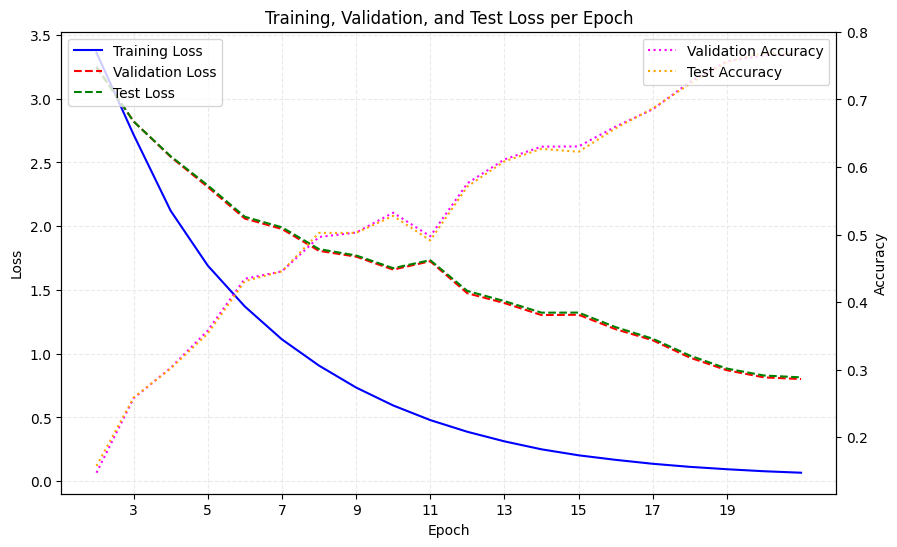

In [11]:
import matplotlib.pyplot as plt

# Ensure 'Test Loss' and 'Validation Loss' are present in your DataFrame
plt.figure(figsize=(10, 6))

# Plot training, test, and validation loss
plt.plot(df['Epoch'], df['Training Loss'], linestyle='-', color='blue', label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], linestyle='--', color='red', label='Validation Loss')
plt.plot(df['Epoch'], df['Test Loss'], linestyle='--', color='green', label='Test Loss')

# Optionally, plot validation and test accuracy if you wish to visualize accuracy on a secondary axis
plt.title('Training, Validation, and Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1, 2))  # Adjust this based on your actual number of epochs
plt.grid(True, which='both', axis='both', linestyle='--', color="#eaeaea")
plt.legend(loc='upper left')

# Create a secondary y-axis to plot accuracy if needed
sec_axis = plt.twinx()
sec_axis.plot(df['Epoch'], df['Validation Accuracy'], linestyle=':', color='magenta', label='Validation Accuracy')
sec_axis.plot(df['Epoch'], df['Test Accuracy'], linestyle=':', color='orange', label='Test Accuracy')  # Optional
sec_axis.set_ylabel('Accuracy')
sec_axis.legend(loc='upper right')

plt.savefig(os.path.join(output_folder, f"training_validation_test_loss_plot_{modelname}_{timestamp}.png"), dpi=300)  # Save the plot as a PNG file
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def get_all_predictions(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.view(-1).tolist())
            all_labels.extend(labels.view(-1).tolist())
    return all_preds, all_labels

# Get predictions and true labels for both datasets
train_preds, train_labels = get_all_predictions(train_loader, model, device)
val_preds, val_labels = get_all_predictions(validation_loader, model, device)
test_preds, test_labels = get_all_predictions(test_loader, model, device)

# Compute confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)
test_cm = confusion_matrix(test_labels, test_preds)


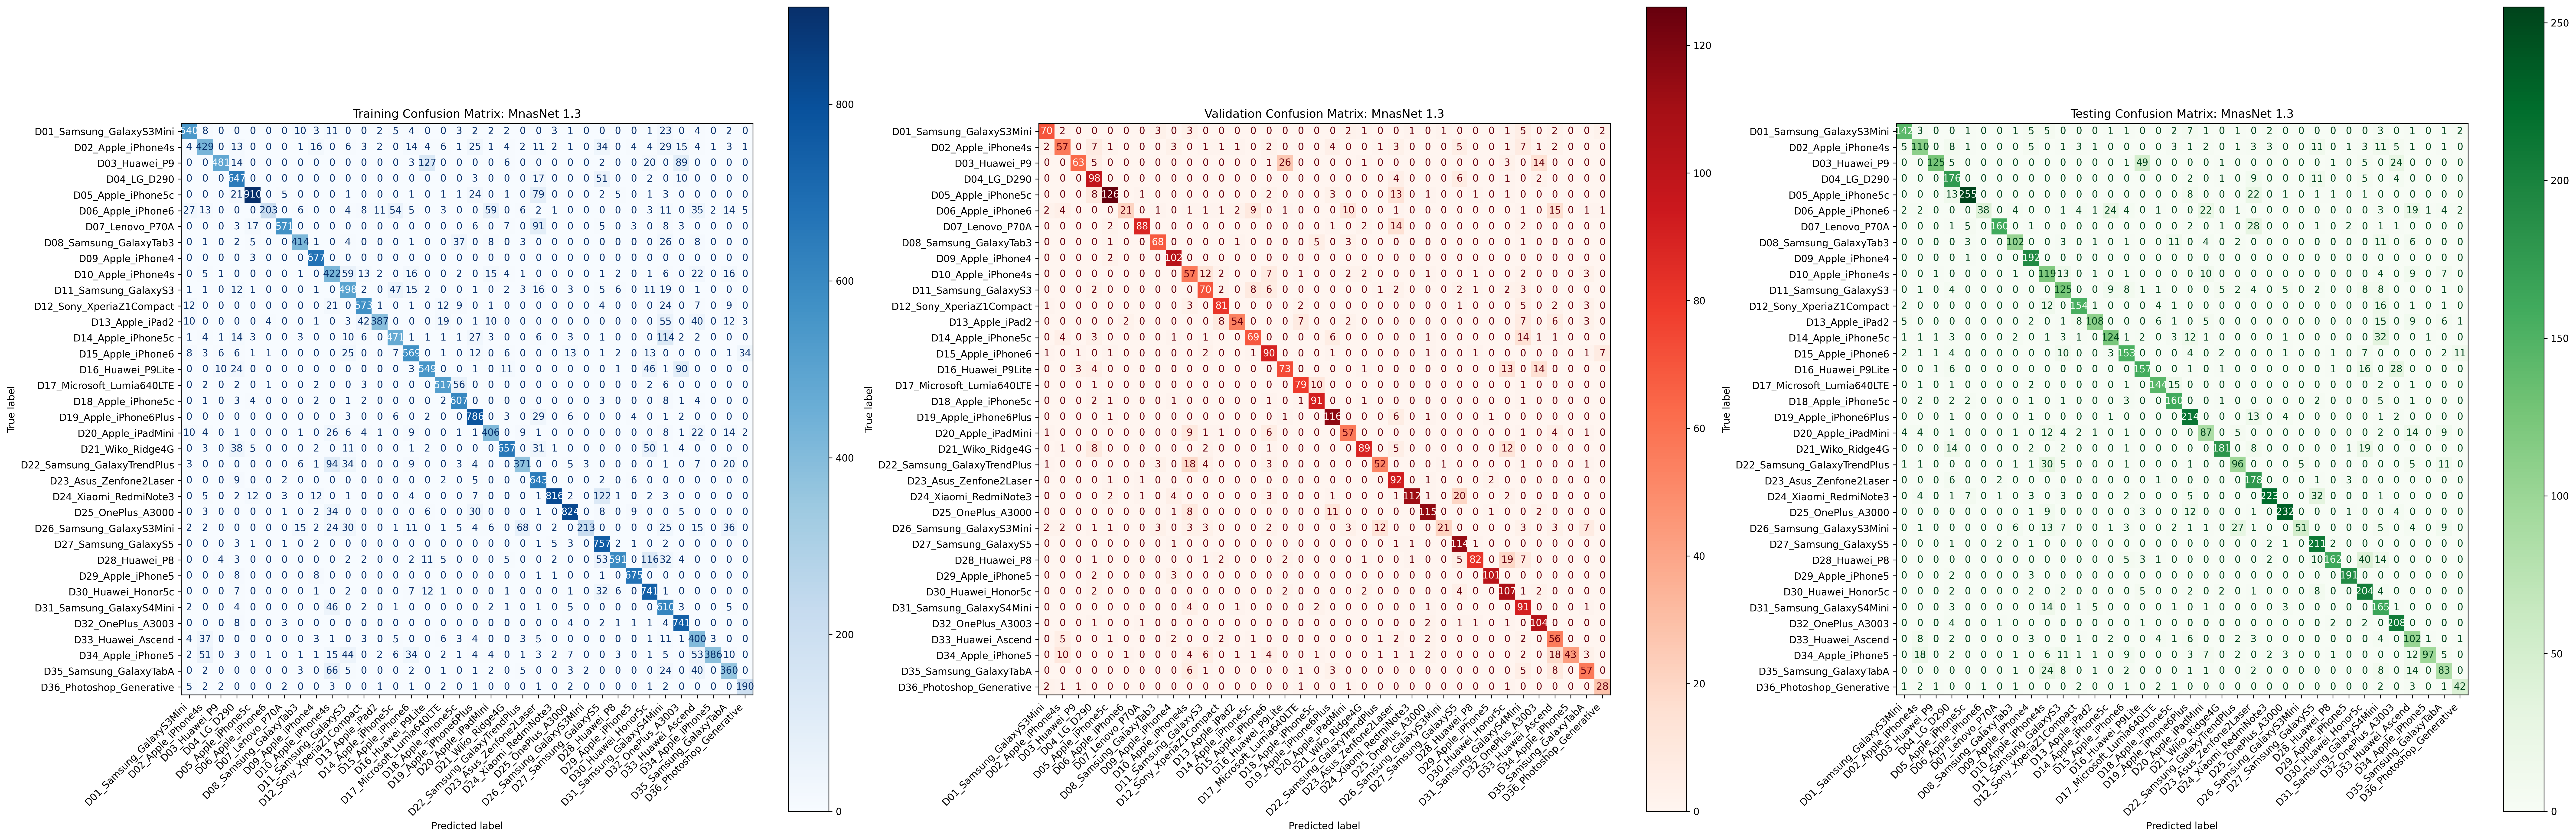

In [13]:
# Plot confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(45, 15), dpi=300)

ConfusionMatrixDisplay(train_cm, display_labels=train_dataset.classes).plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Training Confusion Matrix: MnasNet 1.3')
axes[0].set_xticklabels(rotation=45, labels=train_dataset.classes, ha= 'right')

ConfusionMatrixDisplay(val_cm, display_labels=validation_dataset.classes).plot(ax=axes[1], cmap=plt.cm.Reds)
axes[1].set_title('Validation Confusion Matrix: MnasNet 1.3')
axes[1].set_xticklabels(rotation=45, labels=validation_dataset.classes, ha='right')

ConfusionMatrixDisplay(test_cm, display_labels=test_dataset.classes).plot(ax=axes[2], cmap=plt.cm.Greens)
axes[2].set_title('Testing Confusion Matrix: MnasNet 1.3')
axes[2].set_xticklabels(rotation=45, labels=test_dataset.classes, ha='right')

plt.savefig(os.path.join(output_folder, f"Confusion_Matrix_MnasNet1.3_{timestamp}.png"), dpi=300)  # Save the plot as a PNG file

plt.show()

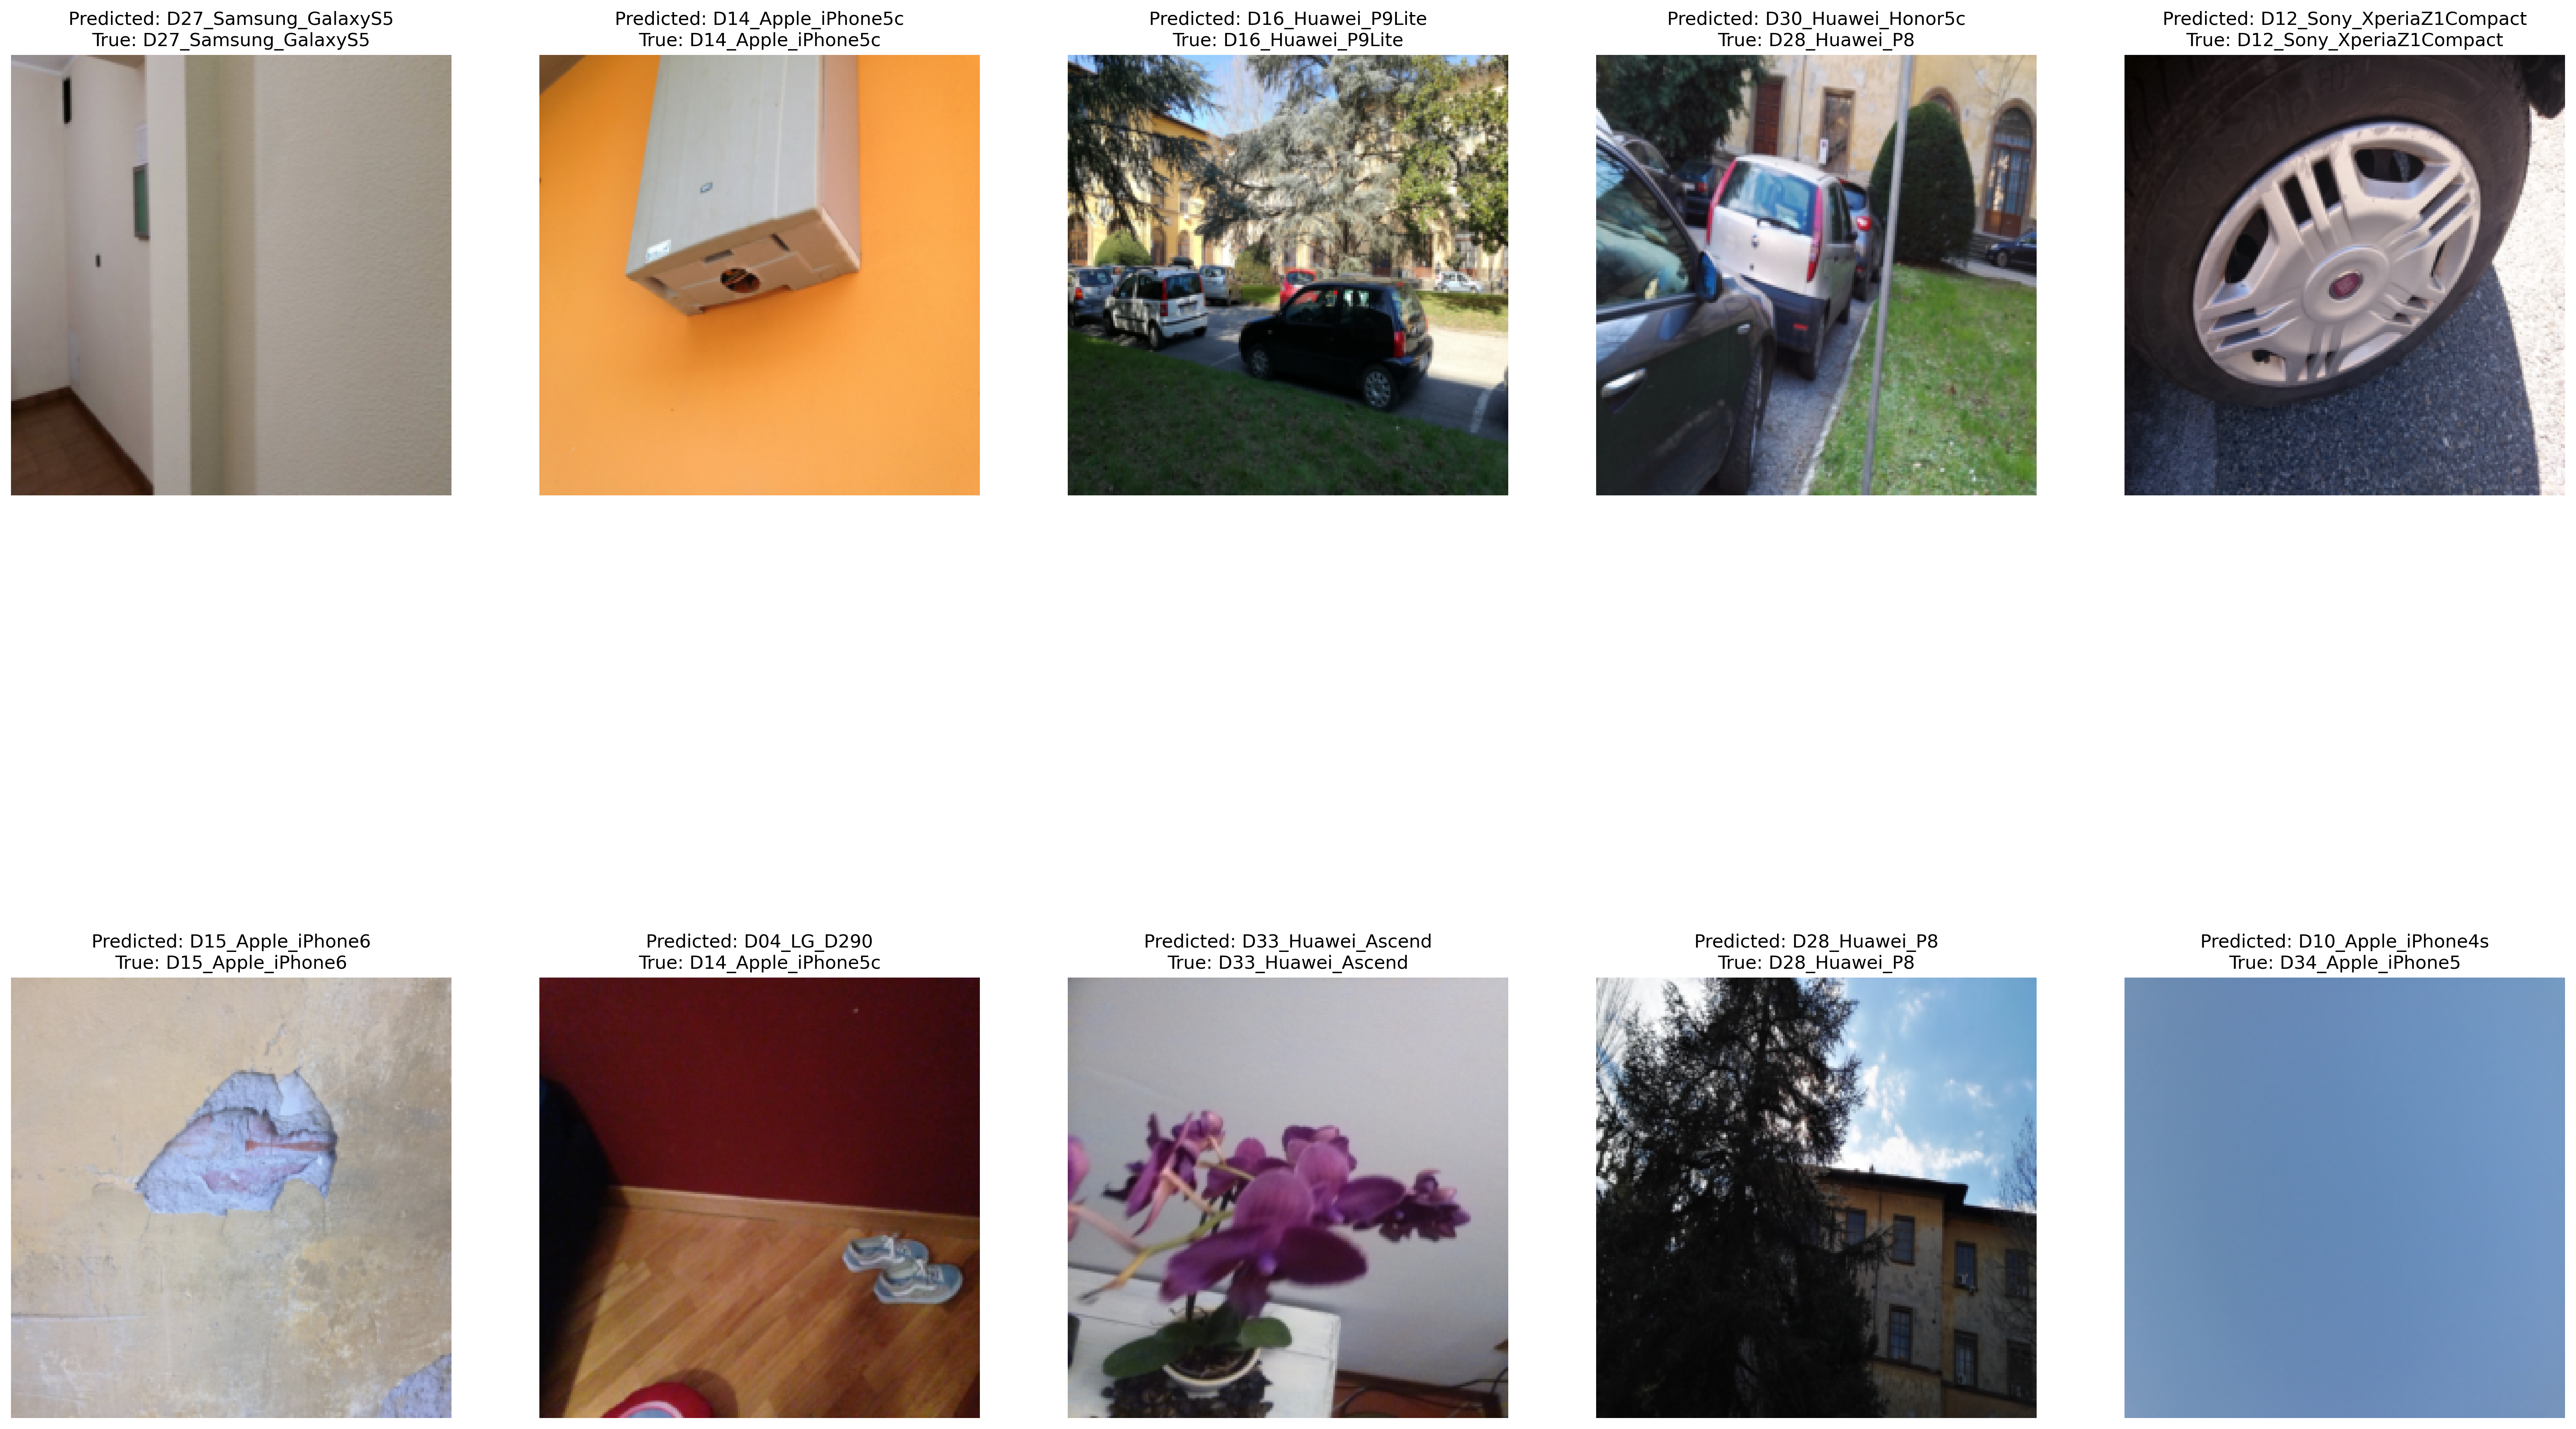

<Figure size 640x480 with 0 Axes>

In [14]:
import torch
import random
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation set
random_indices = random.sample(range(len(validation_dataset)), 10)
images, true_labels = zip(*[validation_dataset[i] for i in random_indices])

# Function to unnormalize and convert a tensor to a PIL image
def unnormalize_and_convert_to_pil(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(tensor.device)
    tensor = tensor.clone().detach()  # Clone the tensor
    tensor = tensor.mul_(std).add_(mean)  # Unnormalize
    tensor = tensor.clamp(0, 1)  # Clamp to the range [0, 1]
    return to_pil_image(tensor)

# Predict and display
plt.figure(figsize=(30, 20), dpi=300)
for i, (image, true_label) in enumerate(zip(images, true_labels)):
    # Predict
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_label = validation_dataset.classes[predicted[0]]

    # Convert image for display
    image_pil = unnormalize_and_convert_to_pil(image)

    # Display
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_pil)
    plt.title(f'Predicted: {predicted_label}\nTrue: {validation_dataset.classes[true_label]}')
    plt.axis('off')
plt.show()
plt.savefig('../output/sample_predictions_MnasNet_1_3.jpg', dpi=300, bbox_inches='tight', pad_inches=0)